In [8]:
import pandas as pd 
import pyomo.environ
from pyomo.environ import *
import numpy as np
import matplotlib.pyplot as plt
from rl4uc.environment import make_env
import sys
# setup python path to be at the root of the project
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from uc_model import solve_milp
from create_milp_dict import create_problem_dict
import Scenarios as scen

In [162]:
def direct_solve(train=True, reserve_pct=None, reserve_mw=None, n_minus_one=False, prof_name = None, date=''):
    if train:
        # scale data later, for now just use 10 gen data
        data = pd.read_csv('../rl4uc/data/train_data_10gen.csv')
    else:
        data = pd.read_csv('../rl4uc/data/test_data_10gen.csv')
        # Pick specific test instance (this is one of 10 days in the test set)
        if date != '':
            data = data[data['date']==date]
    env = make_env(num_gen=5, dispatch_freq_mins=30)
    # scale data to match number of generators
    demand = data['demand'].values * (env.num_gen / 10)
    wind = data['wind'].values * (env.num_gen / 10)
    data['demand'] = demand
    data['wind'] = wind
    # Create scenario tree, in our case it is hard-coded to be deterministic
    tree = scen.Tree('Determ', data, env)
    # Create problem dictionary
    instance = create_problem_dict(demand, wind, env, reserve_pct=reserve_pct, reserve_mw=reserve_mw, n_minus_one=n_minus_one, prof_name=prof_name)
    net_demand = np.sum(demand-wind)
    model, time = solve_milp(instance, Tree=tree)
    costs = value(model.obj)
    cost_per_Mwh = 2 * costs / net_demand
    return model, time, costs, cost_per_Mwh

In [129]:
model, time, cost, costPMwH = direct_solve(reserve_pct=0, train = False, date='2017-06-25')

[773.94995319 751.72116563 740.12453851 733.4305092  729.26784781
 720.35439989 721.84819146 721.36335748 710.16570802 701.18032249
 699.21483427 703.63142606 716.09118213 722.90124925 729.70416168
 736.6588854  766.2632291  796.24469572 828.75753025 853.429876
 862.52414466 871.08193375 872.92422946 867.82572015 867.12949324
 866.88310822 864.17807425 857.63624691 856.43970458 853.90118197
 853.31383819 866.57115891 882.554587   909.60570802 923.79848599
 936.49747239 942.04582358 904.69029775 841.20114146 792.47347171
 724.84963735 836.76630993 857.46057118 854.02146104 889.02199625
 853.28154336 800.8016844  787.10240603]
building model

c_LS: $5000.0 / MW
c_WS: $100.0 / MW

model setup complete
solving
Solved after:  1 s


In [130]:
cost, costPMwH

(376468.2083124336, 19.329413633439692)

In [131]:
dates = [
    '2017-06-25', '2016-07-25', '2019-05-22', '2018-03-18', '2018-05-30', 
    '2017-05-12', '2017-05-26', '2018-09-11', '2018-11-13', '2017-04-07',
    '2017-03-18', '2019-11-09', '2017-12-30', '2019-10-30', '2019-04-03',
    '2018-01-15', '2018-03-08', '2016-11-21','2016-01-12', '2017-12-18'
]

In [163]:
norm_costs = []
costs = []
for date in dates:
    model, time, total_cost, cost_per_MWh = direct_solve(reserve_pct=0, train = False, date=date)
    norm_costs.append(cost_per_MWh)
    costs.append(total_cost)

[386.9749766  375.86058282 370.06226925 366.7152546  364.63392391
 360.17719995 360.92409573 360.68167874 355.08285401 350.59016124
 349.60741714 351.81571303 358.04559106 361.45062463 364.85208084
 368.3294427  383.13161455 398.12234786 414.37876513 426.714938
 431.26207233 435.54096688 436.46211473 433.91286008 433.56474662
 433.44155411 432.08903713 428.81812346 428.21985229 426.95059098
 426.65691909 433.28557946 441.2772935  454.80285401 461.89924299
 468.24873619 471.02291179 452.34514887 420.60057073 396.23673586
 362.42481867 418.38315496 428.73028559 427.01073052 444.51099813
 426.64077168 400.4008422  393.55120301]
building model

c_LS: $5000.0 / MW
c_WS: $100.0 / MW

model setup complete
solving
Solved after:  0 s
[353.56525204 331.51605436 321.23507404 332.15991551 329.36272486
 334.89530041 367.82561589 367.15150028 315.36312598 292.36476185
 292.84465109 307.04535097 319.81548185 300.83761729 326.61985593
 347.90421229 383.41003595 374.66503166 395.30923598 412.29019057
 

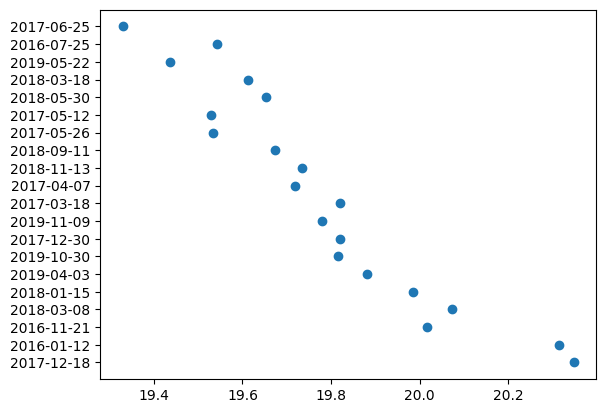

In [157]:
plt.scatter(norm_costs[::-1], dates[::-1])

In [164]:
np.mean(costs)

218772.07848726003